In [2]:
from scipy import io
import numpy as np
import pandas as pd

In [3]:
class matlab_reader():
    def __init__(self,file):
        self.file_path = file
        self.data = io.loadmat(file)
        self.data_info = io.whosmat(file)

        self.data_airs = self.data['Airs']

        # to get night values use mat_data['Airs']['NH'][x][x][x][x][1][x][x][x]
        # to get day values use   mat_data['Airs']['NH'][x][x][x][x][0][x][x][x]

        # to get tp values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][0]
        # to get bg values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][1]
        # to get A  values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][2]
        # to get ha values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][3]
        # to get k  values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][4]
        # to get l  values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][5]
        # to get m  values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][6]
        # to get mfx values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][7]
        # to get mfy values use mat_data['Airs']['NH'][x][x][x][x][x][x][x][8]


        # new_data[0] gives the temperature matrix 501x501 for altitude at lowest level 24
        # new_data[1] gives the temperature matrix 501x501 for altitude at lowest level 30
        # new_data[2] gives the temperature matrix 501x501 for altitude at lowest level 36
        # new_data[3] gives the temperature matrix 501x501 for altitude at lowest level 42
        # new_data[4] gives the temperature matrix 501x501 for altitude at lowest level 48
        
        self.mappings = {"day" : 0,
                        "night": 1,
                        "tp" : 0,
                        "bg" : 1,
                        "a" : 2,
                        "ha" : 3,
                        "k" : 4,
                        "l" : 5,
                        "m" : 6,
                        "mfx" : 7,
                        "mfy" : 8,
                        24 : 0,
                        30 : 1,
                        36 : 2,
                        42 : 3,
                        48 : 4}
    def select(self,
        hemisphere = 'NH',
        daytime = 'Night',
        data_field = 'tp',
        altitude = None):
        ''' 
        Returns a selection on the dataset filtered based on the input values
        hemisphere : selects what hemisphere to select data, North or South
        daytime : selects what time of day to collect values, Night or Day
        data_field : selects data field from tp (temperature) , bg , a , ha , k, l , m , mfx and mfy.
        '''
        
        data_ = self.data_airs[hemisphere.upper()][0][0][0][0][self.mappings[daytime.lower()]][0][0][self.mappings[data_field.lower()]]
        
        # transpose the data to have 5, 501x501 arrays, each for a different altitude level
        new_data = np.transpose(np.transpose(data_, (2, 0, 1)), (0, 2, 1)) 
        
        if altitude is not None:
            new_data = new_data[self.mappings[altitude]]

        print(np.shape(new_data))
        return new_data

# Example 

# matlab = matlab_reader('AIRS_40KM_2022/20220125_AIRS_3DST-1_40km_grid.mat')

# temp_data = matlab.select(
#     hemisphere= 'nh',
#     data_field='tp',
#     daytime='night',
#     altitude=24)      


(501, 501)


In [194]:
class map_grid():
    '''
    Map_grid creates a grid object of coordinates to simply selection of geographical areas.

    '''
    def __init__(self):
        
        self.nh_lat = np.genfromtxt('Airs_nh_lat.csv', delimiter=',')
        self.nh_lon = np.genfromtxt('Airs_nh_lon.csv', delimiter=',')
        self.sh_lat = np.genfromtxt('Airs_sh_lat.csv', delimiter=',')
        self.sh_lon = np.genfromtxt('Airs_sh_lon.csv', delimiter=',')

        self.nh_stacked = np.stack((self.nh_lat, self.nh_lon), axis=2)
        self.sh_stacked = np.stack((self.sh_lat, self.sh_lon), axis=2)

    def select_area_indexer(self, min_lat,max_lat,min_lon,max_lon):
        '''
        Selects coordinates for a range of longitudes and latitudes.
        Output is an array of indeces of shape (501,501) used to filter the output from  mamatlab_reader.select()
        '''
        if max_lat < 0:
            a = self.sh_stacked
        else:
            a = self.nh_stacked
        a = np.where((a[...,0] > min_lat) & (a[...,0] < max_lat) & (a[...,1] > min_lon) & (a[...,1] < max_lon) )
        return np.transpose(a)


In [197]:
temp_data = matlab.select(
    hemisphere= 'nh',
    data_field='tp',
    daytime='night',
    altitude=24)   

(501, 501)


In [202]:
grid = map_grid()

matlab = matlab_reader('AIRS_40KM_2022/20220126_AIRS_3DST-1_40km_grid.mat')

temp_data = matlab.select(
    hemisphere= 'SH',
    data_field='tp',
    daytime='night',
    altitude=36)   

select_area_indexer = grid.select_area_indexer(
    min_lat= -34,
    max_lat= -22,
    min_lon= -74,
    max_lon= -63)

def data_filtering(select_area_indexer,data):
    temp_data_select = data[select_area_indexer[:,0], select_area_indexer[:,1]]
    mask = np.full((500, 500), np.nan)
    mask[select_area_indexer[:,0], select_area_indexer[:,1]] = temp_data_select
    return mask


mask = data_filtering(select_area_indexer = select_area_indexer ,data = temp_data )

(501, 501)


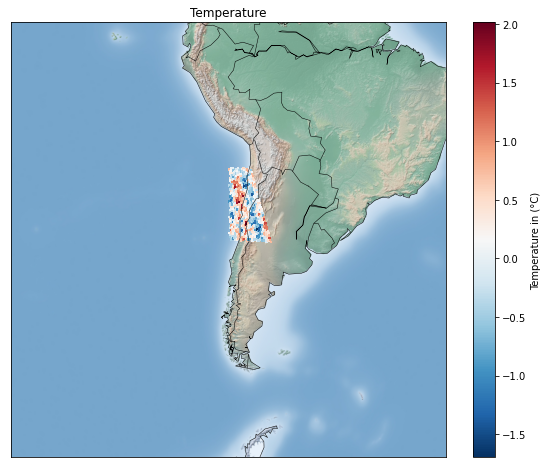

In [203]:
# matlab = matlab_reader('AIRS_40KM_2022/20220126_AIRS_3DST-1_40km_grid.mat')

# temp_data = matlab.select(
#     hemisphere= 'SH',
#     data_field='tp',
#     daytime='night',
#     altitude=36)     

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 8))

m = Basemap(projection='stere', resolution='c',
            width=8E6, height=8E6, 
            lat_0=-34, lat_1=-22,
            lon_0=-74,lon_1 = -22)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.sh_lon, 
             grid.sh_lat, 
             mask,
             latlon=True, cmap='RdBu_r',
             shading='auto')

m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

plt.title('Temperature')
plt.colorbar(label='Temperature in (°C)')

array([[ 0.2338833 ,  0.72557545,  0.6841717 , ..., -0.71857363,
        -0.18388788,  0.57238257],
       [ 0.2039295 ,  0.28435087, -0.57337457, ..., -0.17180575,
        -0.29477203,  0.60983616],
       [ 0.36386606, -0.21109529, -0.53333426, ...,  0.0583132 ,
        -0.05976918,  0.3577144 ],
       ...,
       [ 0.16220653,  0.19033998,  0.34924573, ...,         nan,
                nan,         nan],
       [-0.34345868, -0.00109939, -0.0094632 , ...,         nan,
                nan,         nan],
       [-0.56784683, -0.14757185,  0.0651984 , ...,         nan,
                nan,         nan]], dtype=float32)